<a href="https://colab.research.google.com/github/abhi99-ut/aih/blob/feature%2Fnoteevents/noteevenets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set UP

**Install libraries**

In [ ]:
# Install spaCy 3.7.x and SciSpacy 0.5.x (both compatible)
!pip install spacy==3.2.3
!python -m spacy download en_core_web_sm
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_sm-0.5.0.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Validate installed models
!python -m spacy validate


2024-10-13 13:23:55.687566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 13:23:55.727563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 13:23:55.739773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 13:23:57.379481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.2.6) =================
ℹ spaCy installation: /usr/local/lib/python3.10/dist-packages/spacy

NAME               SPACY            VERSION                    

In [ ]:
import spacy

from spacy import displacy
from IPython.display import display, HTML

# Load the small English model
nlp_spacy = spacy.load("en_core_web_sm")
nlp_sci = spacy.load("en_core_sci_sm")
nlp_bc5cdr = spacy.load("en_ner_bc5cdr_md")

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


#### Test model load

In [ ]:
text = "Apple is looking at buying U.K. startup for #1 billion."

# Test the model with some sample text
doc = nlp_spacy(text)
for token in doc:
    print(token.text, token.pos_, token.dep_)


TApple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN dobj
startup VERB dep
for ADP prep
# SYM quantmod
1 NUM compound
billion NUM pobj
. PUNCT punct


In [ ]:
# Load the SciSpacy model (e.g., en_core_sci_sm)
nlp_sci = spacy.load("en_core_sci_sm")

# Example: Process biomedical text
text = "The patient was diagnosed with chronic kidney disease and hypertension."
doc = nlp_sci(text)

# Extract entities
for ent in doc.ents:
    print(ent.text, ent.label_)


patient ENTITY
diagnosed ENTITY
chronic kidney disease ENTITY
hypertension ENTITY


### Load Renal Patients dataset

In [ ]:
from google.colab import auth
auth.authenticate_user()
import pandas as pd
from google.cloud import bigquery

In [ ]:
query = """
select * from mimic_data_prep.renal_patients_noteevents """

In [ ]:
client = bigquery.Client()
df = client.query(query).to_dataframe()

In [ ]:
# #df.to_csv('renal_patients_noteevents.csv', index=False)
# import pandas as pd
# df = pd.read_csv('renal_patients_noteevents.csv')

### EDA - to find relevant subgroup

In [ ]:
df.shape

(17938, 14)

In [ ]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,220707,31004,197632,2158-12-03,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Left atrial abnormality. Left ve...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
1,205881,4313,141826,2174-02-23,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Diffuse non-specific ST-T wave a...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
2,283762,15119,164611,2174-02-23,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Low precordial QRS voltage. Non-...,5856,End stage renal disease,End stage renal disease
3,283763,15119,164611,2174-02-18,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm\nLow precordial lead QRS voltage ...,5856,End stage renal disease,End stage renal disease
4,222495,90861,198660,2198-09-23,NaT,NaT,ECG,Report,<NA>,<NA>,Normal sinus rhythm. Left bundle-branch block...,5845,"Ac kidny fail, tubr necr",Acute kidney failure with lesion of tubular ne...


In [ ]:
df[['ICD9_CODE','SHORT_TITLE','LONG_TITLE']].drop_duplicates()

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
2,5856,End stage renal disease,End stage renal disease
4,5845,"Ac kidny fail, tubr necr",Acute kidney failure with lesion of tubular ne...
35,585,None,None
438,5848,Acute kidney failure NEC,Acute kidney failure with other specified path...
531,5859,Chronic kidney dis NOS,"Chronic kidney disease, unspecified"
8760,5846,"Ac kidny fail, cort necr",Acute kidney failure with lesion of renal cort...


In [ ]:
df.groupby(['SHORT_TITLE'])[['SHORT_TITLE']].value_counts()

,count
SHORT_TITLE,
"Ac kidny fail, cort necr",43
"Ac kidny fail, tubr necr",4015
Acute kidney failure NEC,360
Acute kidney failure NOS,12764
Chronic kidney dis NOS,6
End stage renal disease,546


In [ ]:
df.groupby(['CATEGORY','SHORT_TITLE'])[['CATEGORY','SHORT_TITLE']].value_counts()

CATEGORY           SHORT_TITLE             
Case Management    Acute kidney failure NOS      15
Consult            Acute kidney failure NOS       1
Discharge summary  Ac kidny fail, cort necr       1
                   Ac kidny fail, tubr necr     128
                   Acute kidney failure NEC       5
                   Acute kidney failure NOS     578
                   Chronic kidney dis NOS         1
                   End stage renal disease       23
ECG                Ac kidny fail, tubr necr     408
                   Acute kidney failure NEC      37
                   Acute kidney failure NOS    1650
                   Chronic kidney dis NOS         2
                   End stage renal disease       69
Echo               Ac kidny fail, tubr necr      90
                   Acute kidney failure NEC       4
                   Acute kidney failure NOS     254
                   Chronic kidney dis NOS         1
                   End stage renal disease       10
General            Ac kidny fail, tubr necr      19
                   Acute kidney failure NEC       6
                   Acute kidney failure NOS      81
Nursing            Ac kidny fail, tubr necr     668
                   Acute kidney failure NEC     106
                   Acute kidney failure NOS    2241
                   End stage renal disease       38
Nursing/other      Ac kidny fail, cort necr      29
                   Ac kidny fail, tubr necr    1187
                   Acute kidney failure NEC       4
                   Acute kidney failure NOS    3099
                   Chronic kidney dis NOS         2
                   End stage renal disease      188
Nutrition          Ac kidny fail, tubr necr      19
                   Acute kidney failure NEC       7
                   Acute kidney failure NOS      66
                   End stage renal disease        1
Physician          Ac kidny fail, tubr necr     505
                   Acute kidney failure NEC      62
                   Acute kidney failure NOS    1591
                   End stage renal disease       16
Radiology          Ac kidny fail, cort necr      13
                   Ac kidny fail, tubr necr     933
                   Acute kidney failure NEC     111
                   Acute kidney failure NOS    2927
                   End stage renal disease      195
Rehab Services     Ac kidny fail, tubr necr       4
                   Acute kidney failure NEC       5
                   Acute kidney failure NOS      33
                   End stage renal disease        1
Respiratory        Ac kidny fail, tubr necr      45
                   Acute kidney failure NEC      13
                   Acute kidney failure NOS     197
                   End stage renal disease        5
Social Work        Ac kidny fail, tubr necr       9
                   Acute kidney failure NOS      31
Name: count, dtype: int64

In [ ]:
df.CATEGORY.value_counts()

,count
CATEGORY,
Nursing/other,4615
Radiology,4228
Nursing,3053
ECG,2194
Physician,2174
Discharge summary,750
Echo,366
Respiratory,260
General,106


In [ ]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,220707,31004,197632,2158-12-03,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Left atrial abnormality. Left ve...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
1,205881,4313,141826,2174-02-23,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Diffuse non-specific ST-T wave a...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
2,283762,15119,164611,2174-02-23,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm. Low precordial QRS voltage. Non-...,5856,End stage renal disease,End stage renal disease
3,283763,15119,164611,2174-02-18,NaT,NaT,ECG,Report,<NA>,<NA>,Sinus rhythm\nLow precordial lead QRS voltage ...,5856,End stage renal disease,End stage renal disease
4,222495,90861,198660,2198-09-23,NaT,NaT,ECG,Report,<NA>,<NA>,Normal sinus rhythm. Left bundle-branch block...,5845,"Ac kidny fail, tubr necr",Acute kidney failure with lesion of tubular ne...


In [ ]:
## get Acute kidney failure NOS
df = df[df.ICD9_CODE == "5849"].reset_index(drop=True)

In [ ]:
df['CATEGORY'].value_counts()

,count
CATEGORY,
Nursing/other,3099
Radiology,2927
Nursing,2241
ECG,1650
Physician,1591
Discharge summary,578
Echo,254
Respiratory,197
General,81


In [ ]:
## get discharge summary
df = df[df.CATEGORY == "Discharge summary"].reset_index(drop=True)

df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,32337,31004,197632,2158-12-18,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2158-12-3**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
1,29936,12712,113665,2196-12-03,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2196-11-30**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
2,29816,4313,141826,2174-02-26,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2174-2-22**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
3,47777,68526,116228,2145-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2145-12-11**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
4,25388,23979,161541,2168-08-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2168-8-17**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"


In [ ]:
df

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,32337,31004,197632,2158-12-18,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2158-12-3**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
1,29936,12712,113665,2196-12-03,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2196-11-30**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
2,29816,4313,141826,2174-02-26,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2174-2-22**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
3,47777,68526,116228,2145-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2145-12-11**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
4,25388,23979,161541,2168-08-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2168-8-17**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573,6209,7251,189182,2151-03-14,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2151-3-4**] D...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
574,13089,9473,125694,2103-03-30,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2103-3-23**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
575,3749,89236,131839,2149-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2149-12-10**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"
576,9959,51178,188927,2123-09-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2123-9-16**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified"


In [ ]:
text = df['TEXT'][0]

In [ ]:
text

"Admission Date:  [**2158-12-3**]              Discharge Date:   [**2158-12-18**]\n\nDate of Birth:  [**2086-8-15**]             Sex:   F\n\nService: MEDICINE\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 898**]\nChief Complaint:\nFailure to thrive\n\nMajor Surgical or Invasive Procedure:\nNasogastric Tube Placement\n\n\nHistory of Present Illness:\n72 yo French Creole-speaking female w/ ALS, who has had a\ndecline in mental status and abilities to perform ADLs over the\nlast 1-2 weeks. Per daughter she is dysarthric at baseline,\nhowever, she has been less responsive and communicative for the\npast week. Not communicating at all. History provided by\ndaughter since patient is now nonverbal and not responding to\nquestions.\n.\nFor the past couple of weeks prior to admission, patient has\nbecome less responsive to their questions and forgetting to eat\nher meals. Usually, meals are delivered during the day and\npatient is able to

### NER

#### en_core_web_sm

In [ ]:
doc = nlp_spacy(text)
html = displacy.render(doc, style="ent")
display(HTML(html))

#### en_core_sci_sm

In [ ]:
doc_sci = nlp_sci(text)
html_sci = displacy.render(doc_sci, style="ent")
display(HTML(html_sci))

In [ ]:
# Extract entities related to chemicals (medications)
medications = [ent.text for ent in doc_sci.ents if ent.label_ == "CHEMICAL"]

#### bc5cdr

In [ ]:
doc_bc5cdr = nlp_bc5cdr(text)

In [ ]:
medications = [ent.text for ent in doc_bc5cdr.ents if ent.label_ == "CHEMICAL"]


In [ ]:
html_bc5cdr = displacy.render(doc_bc5cdr, style="ent")

# Display the HTML output in Colab
display(HTML(html_bc5cdr))

### Word2Vec

#### Pre-processing

In [135]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords


def remove_special_characters(text):
    # Remove numbers followed by punctuation (e.g., '7.')
    text = re.sub(r'\d+', '', text) # remove number
    text = re.sub(r'\b\d+[.,!?]\b', '', text)  # Remove numbers followed by punctuation
    text = re.sub(r"[^a-zA-Z0-9.,!?\'\` ]+", ' ', text)  # Keep only alphanumeric characters and punctuation
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words and len(word) > 2]) # remove words less than 2 char

def preprocess_discharge_summary(text):
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_stopwords(text)
    return text

df["CLEAN_TEXT"] = df["TEXT"].apply(preprocess_discharge_summary)
df['TOKEN_TEXT'] = df['CLEAN_TEXT'].apply(lambda x: x.split())

In [133]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE,CLEAN_TEXT,TOKEN_TEXT,DRUG_DISEASE_PAIR
0,32337,31004,197632,2158-12-18,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2158-12-3**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(iron, hemorrhage), (iron, infarction), (na, ..."
1,29936,12712,113665,2196-12-03,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2196-11-30**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(baclofen, diarrhea jaundice), (hepatitis c c..."
2,29816,4313,141826,2174-02-26,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2174-2-22**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(unasyn, infected ulcer), (labetalol, infecte..."
3,47777,68526,116228,2145-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2145-12-11**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(oxygen, hypotension), (na, glucose lactate),..."
4,25388,23979,161541,2168-08-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2168-8-17**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(cough jt pain, diarrhea), (cough jt pain, pa..."


In [137]:
text = df["CLEAN_TEXT"][0]
text

"admission date discharge date date birth sex service medicine allergies patient recorded known allergies drugs attending first name chief complaint failure thrive major surgical invasive procedure nasogastric tube placement history present illness french creole speaking female als, decline mental status abilities perform adls last weeks. per daughter dysarthric baseline, however, less responsive communicative past week. communicating all. history provided daughter since patient nonverbal responding questions. past couple weeks prior admission, patient become less responsive questions forgetting eat meals. usually, meals delivered day patient able feed herself. lately, family found meals untouched resorted feeding forcibly. wanted get bed past couple days occasionally urinary bowel incontinence bed. patient requiring assistance walking get bathroom. ed, labs remarkable sodium greater assay serum sodium serum osms also notable nephrology contact name management extreme hypernatremia arf

In [ ]:
pp_text = preprocess_discharge_summary(text)

In [ ]:
pp_text
doc_bc5cdr = nlp_bc5cdr(pp_text)
html_bc5cdr = displacy.render(doc_bc5cdr, style="ent")

# Display the HTML output in Colab
display(HTML(html_bc5cdr))


#### Training

In [139]:
from gensim.models import Word2Vec

# Convert the preprocessed text into a list of lists for Word2Vec
sentences = df['TOKEN_TEXT'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=10, workers=4)

# Save the model for future use
model.save("word2vec_discharge_summaries.model")

# Load the saved Word2Vec model
loaded_model = Word2Vec.load("word2vec_discharge_summaries.model")

In [193]:
loaded_model.wv.most_similar('pain')

[('pain.', 0.8794722557067871),
 ('pain,', 0.8086318969726562),
 ('sob', 0.7901192307472229),
 ('complained', 0.7892394065856934),
 ('dyspnea', 0.783547580242157),
 ('discomfort', 0.7750874757766724),
 ('exertion,', 0.7662720680236816),
 ('breath.', 0.7530032992362976),
 ('nausea', 0.7529860734939575),
 ('sob,', 0.7448972463607788)]

In [186]:
loaded_model.wv['patient']

array([ 2.91619562e-02,  6.97434604e-01,  6.38942242e-01,  1.65210426e-01,
        4.04245734e-01, -4.62138802e-01,  4.38666195e-01, -3.48141938e-01,
       -2.04136163e-01, -2.58580863e-01,  2.63856322e-01, -7.61180520e-01,
        1.05268516e-01,  1.98223423e-02,  4.73522484e-01, -9.15573537e-01,
        3.17398310e-01,  1.04877569e-01,  8.62167954e-01, -5.96567094e-01,
       -6.05764568e-01,  4.20302898e-01, -8.43117535e-01, -4.71555918e-01,
        1.74107909e-01,  2.83868134e-01,  1.10098444e-01,  7.27835357e-01,
        2.66422600e-01, -4.90982413e-01,  1.06896734e+00,  1.12234747e+00,
       -7.91059077e-01, -2.19265044e-01, -6.98893785e-01,  2.80682355e-01,
       -1.75973535e-01,  1.40752420e-01,  3.63913894e-01, -8.40865314e-01,
        7.60656118e-01,  5.62474481e-04,  1.01215646e-01, -3.94648969e-01,
       -8.20694447e-01,  1.23223945e-01, -1.16802669e+00, -5.55381060e-01,
        4.65497702e-01,  4.36187565e-01, -8.52718726e-02,  7.21199140e-02,
       -2.13133723e-01,  

### TNSE - Visualization

#### Unigram

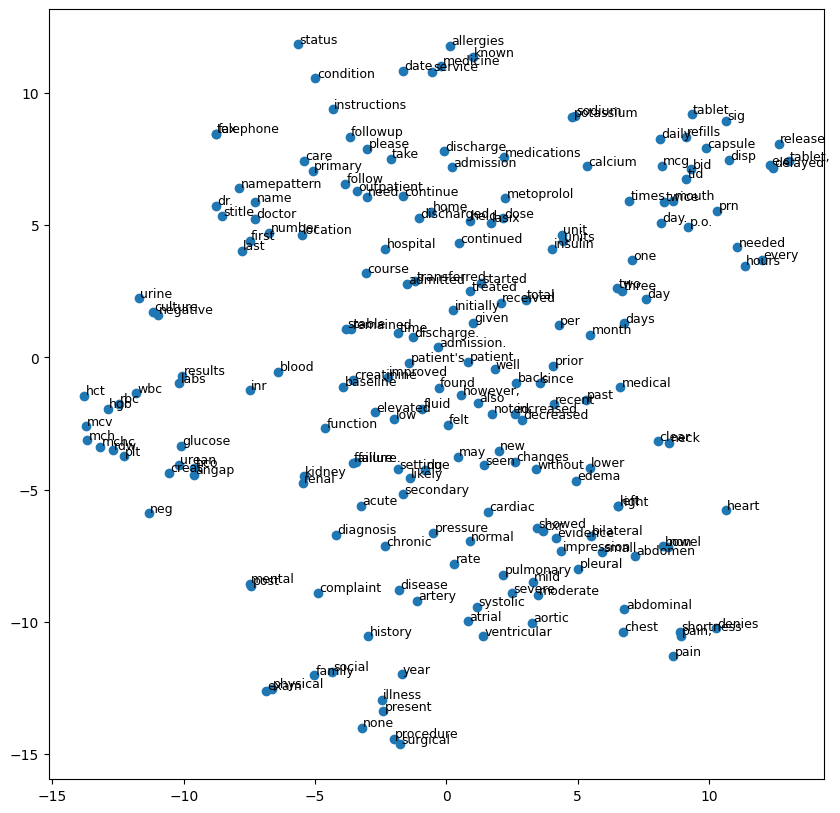

In [142]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select a few sample words from the vocabulary
words = list(model.wv.index_to_key)[:200]

# Get their vector representations
word_vectors = model.wv[words]

# Use t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the 2D word vectors
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# Annotate the points with words (reduce font size and add offset to prevent overlap)
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2d[i, 0] + 0.05, word_vectors_2d[i, 1] + 0.05), fontsize=9)

plt.show()


In [143]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [144]:
sentences = df['TOKEN_TEXT'].tolist()

#### Bigram

In [145]:
bigram = Phrases(sentences, min_count=5, threshold=100)  # Higher threshold fewer phrases.
bigram_phraser = Phraser(bigram)

In [146]:
sentences_with_bigrams = [bigram_phraser[sent] for sent in sentences]


In [147]:
model_bi = Word2Vec(sentences=sentences_with_bigrams, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model_bi.save("word2vec_with_bigrams.model")

# Check the vocabulary to ensure bigrams are included
words_bi = list(model_bi.wv.index_to_key)
print(words_bi[:100])

['name', 'tablet', 'patient', 'blood', 'daily', 'sig', 'hospital', 'one', 'discharge', 'last', 'renal', 'history', 'day', 'left', 'acute', 'admission', 'right', 'given', 'also', 'medications', 'date', 'namepattern', 'first', 'chronic', 'failure', 'urine', 'likely', 'day.', 'follow', 'continued', 'started', 'showed', 'normal', 'per', 'prior', "patient's", 'please', 'course', 'pain', 'due', 'home', 'time', 'refills', 'two', 'secondary', 'disp', 'stitle', 'baseline', 'dr.', 'times', 'capsule', 'denies', 'evidence', 'negative', 'mild', 'noted', 'admitted', 'pulmonary', 'creatinine', 'found', 'location', 'chest', 'days', 'well', 'increased', 'dose', 'without', 'family', 'heart', 'low', 'improved', 'telephone_fax', 'elevated', 'lasix', 'hgb_hct', 'prn', 'wbc_rbc', 'decreased', 'pressure', 'initially', 'stable', 'abdominal', 'recent', 'mcv_mch', 'mchc_rdw', 'unit', 'needed', 'disease', 'plt', 'setting', 'treated', 'doctor', 'held', 'received', 'past_medical', 'glucose_urean', 'discharge.', 'k

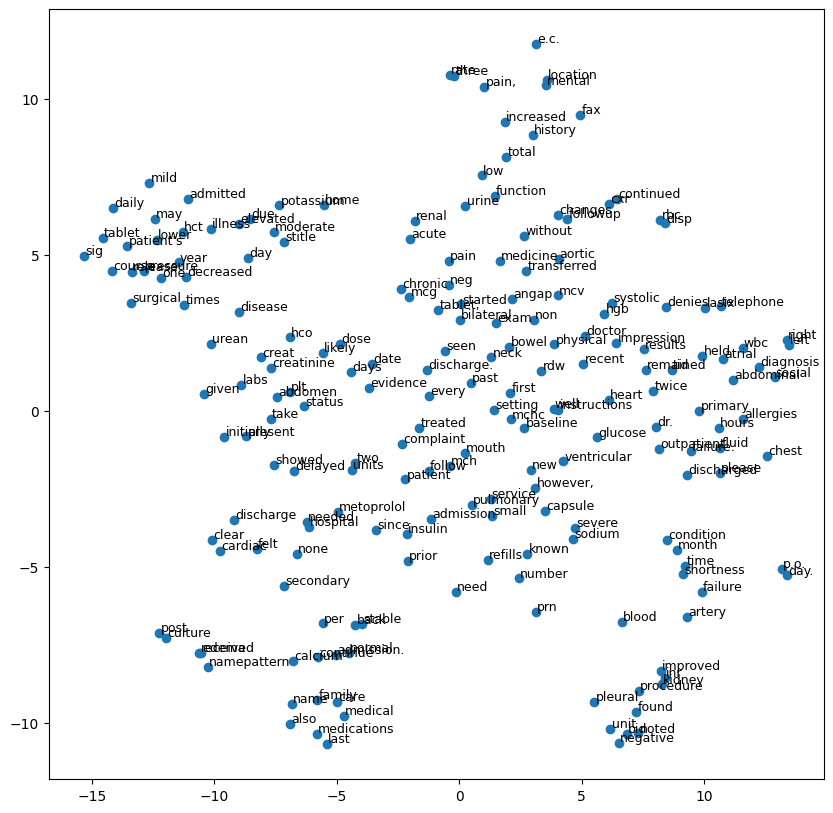

In [148]:
# Select a few sample words from the vocabulary
words_bi = list(model_bi.wv.index_to_key)[:200]

# Get their vector representations
word_vectors = model_bi.wv[words_bi]

# Use t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the 2D word vectors
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])

# Annotate the points with words (reduce font size and add offset to prevent overlap)
for i, word in enumerate(words):
    plt.annotate(word, (word_vectors_2d[i, 0] + 0.05, word_vectors_2d[i, 1] + 0.05), fontsize=9)

plt.show()


### Topic Modelling - LDA

In [150]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords


# Convert the preprocessed text into a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['CLEAN_TEXT'])

# Fit LDA model (specify the number of topics)
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Example: 5 topics
lda.fit(doc_term_matrix)

# Display the top words in each topic
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([words[i] for i in topic.argsort()[-10:]])


Topic 0:
['right', 'stitle', 'cancer', 'renal', 'given', 'acute', 'status', 'urine', 'history', 'blood']
Topic 1:
['left', 'pain', 'failure', 'history', 'renal', 'blood', 'day', 'sig', 'daily', 'tablet']
Topic 2:
['left', 'acute', 'creatinine', 'showed', 'status', 'failure', 'history', 'blood', 'renal', 'day']
Topic 3:
['urine', 'pain', 'renal', 'blood', 'history', 'neg', 'day', 'daily', 'sig', 'tablet']
Topic 4:
['given', 'negative', 'acute', 'liver', 'history', 'normal', 'right', 'left', 'renal', 'blood']


### NER Application : drug-disease pairs

In [151]:

doc_bc5cdr
# Function to pair drugs and diseases based on proximity
def pair_drugs_diseases(doc):
    drugs = [ent for ent in doc.ents if ent.label_ == "CHEMICAL"]
    diseases = [ent for ent in doc.ents if ent.label_ == "DISEASE"]

    # Create a list of drug-disease pairs based on proximity
    pairs = []
    for drug in drugs:
        for disease in diseases:
            # If the entities are close to each other in the text
            if abs(drug.start - disease.start) <= 10:  # Adjust distance threshold
                pairs.append((drug.text, disease.text))

    return pairs

# Extract drug-disease pairs
pairs = pair_drugs_diseases(doc_bc5cdr)
print("Drug-Disease Pairs:", pairs)


Drug-Disease Pairs: [('iron', 'hemorrhage'), ('iron', 'infarction'), ('na', 'hypernatremia'), ('creatinine', 'acute renal failure'), ('glycopyrrolate', 'anemia'), ('iron', 'anemia'), ('iron', 'chronic disease'), ('iron', 'bruising'), ('metoprolol', 'hypovolemia'), ('metoprolol', 'obstructive sleep apnea'), ('glycopyrrolate', 'sialorrhea'), ('sodium', 'back level acute illness')]


In [152]:
pairs

[('iron', 'hemorrhage'),
 ('iron', 'infarction'),
 ('na', 'hypernatremia'),
 ('creatinine', 'acute renal failure'),
 ('glycopyrrolate', 'anemia'),
 ('iron', 'anemia'),
 ('iron', 'chronic disease'),
 ('iron', 'bruising'),
 ('metoprolol', 'hypovolemia'),
 ('metoprolol', 'obstructive sleep apnea'),
 ('glycopyrrolate', 'sialorrhea'),
 ('sodium', 'back level acute illness')]

In [153]:
# Function to apply NER and extract drug-disease pairs for each discharge summary
def extract_pairs_from_summary(summary):
    doc = nlp_bc5cdr(summary)
    return pair_drugs_diseases(doc)

# Apply to each discharge summary in the dataframe
df['DRUG_DISEASE_PAIR'] = df['CLEAN_TEXT'].apply(extract_pairs_from_summary)

# Display the drug-disease pairs
df[['CLEAN_TEXT', 'DRUG_DISEASE_PAIR']].head()


,CLEAN_TEXT,DRUG_DISEASE_PAIR
0,admission date discharge date date birth sex s...,"[(sodium, hypernatremia), (folate, hemorrhage)..."
1,admission date discharge date date birth sex s...,"[(baclofen, diarrhea jaundice), (nadolol, asci..."
2,admission date discharge date date birth sex s...,"[(kayexalate, ulcer), (kayexalate, infected ul..."
3,admission date discharge date date birth sex s...,"[(oxygen, hypotension), (glucose, glucose lact..."
4,admission date discharge date date birth sex s...,"[(sodium potassium chloride, hazy), (osmolal, ..."


In [120]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE,CLEAN_TEXT,TOKEN_TEXT,DRUG_DISEASE_PAIR
0,32337,31004,197632,2158-12-18,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2158-12-3**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex f...,"[admission, date, discharge, date, date, birth...","[(iron, hemorrhage), (iron, infarction), (na, ..."
1,29936,12712,113665,2196-12-03,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2196-11-30**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex f...,"[admission, date, discharge, date, date, birth...","[(baclofen, diarrhea jaundice), (hepatitis c c..."
2,29816,4313,141826,2174-02-26,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2174-2-22**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(unasyn, infected ulcer), (labetalol, infecte..."
3,47777,68526,116228,2145-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2145-12-11**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex f...,"[admission, date, discharge, date, date, birth...","[(oxygen, hypotension), (na, glucose lactate),..."
4,25388,23979,161541,2168-08-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2168-8-17**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex f...,"[admission, date, discharge, date, date, birth...","[(cough jt pain, diarrhea), (cough jt pain, pa..."


In [154]:
# Flatten the list of drug-disease pairs across all discharge summaries
all_pairs = [pair for pairs_list in df['DRUG_DISEASE_PAIR'] for pair in pairs_list]


In [155]:
all_pairs

[('sodium', 'hypernatremia'),
 ('folate', 'hemorrhage'),
 ('iron', 'hemorrhage'),
 ('iron', 'infarction'),
 ('sodium', 'hypernatremia'),
 ('creatinine', 'acute renal failure'),
 ('glycopyrrolate', 'anemia'),
 ('iron', 'anemia'),
 ('iron', 'chronic disease'),
 ('iron', 'bruising'),
 ('metoprolol', 'hypovolemia'),
 ('metoprolol', 'obstructive sleep apnea'),
 ('glycopyrrolate', 'sialorrhea'),
 ('riluzole', 'sialorrhea'),
 ('docusate sodium', 'constipation'),
 ('sodium', 'back level acute illness'),
 ('baclofen', 'diarrhea jaundice'),
 ('nadolol', 'ascites'),
 ('ulcer duodenal bulb .asthma .mildly dilated left atrium, trace ar, trivial mr, last name tte .no diabetes',
  'esophagitis'),
 ('ulcer duodenal bulb .asthma .mildly dilated left atrium, trace ar, trivial mr, last name tte .no diabetes',
  'hernia'),
 ('ulcer duodenal bulb .asthma .mildly dilated left atrium, trace ar, trivial mr, last name tte .no diabetes',
  'hypertensive gastropathy'),
 ('cholesterol hypertension fractured jaw r

In [158]:
from collections import Counter

# Count the frequency of each drug-disease pair
pair_counts = Counter(all_pairs)

# Print the 10 most common drug-disease pairs
most_common_pairs = pair_counts.most_common(20)
print("Top 20 most common drug-disease pairs:")
for pair, count in most_common_pairs:
    print(f"{pair}: {count} occurrences")


Top 20 most common drug-disease pairs:
('iron', 'anemia'): 103 occurrences
('creatinine', 'acute renal failure'): 58 occurrences
('acetaminophen', 'pain'): 55 occurrences
('oxycodone', 'pain'): 53 occurrences
('tylenol', 'pain'): 51 occurrences
('creatinine', 'renal failure'): 47 occurrences
('docusate sodium', 'constipation'): 34 occurrences
('morphine', 'pain'): 29 occurrences
('levofloxacin', 'pneumonia'): 29 occurrences
('creatinine', 'hyperkalemia'): 28 occurrences
('potassium', 'hyperkalemia'): 28 occurrences
('trazodone', 'insomnia'): 25 occurrences
('creatinine', 'chronic renal failure'): 22 occurrences
('levothyroxine', 'hypothyroidism'): 22 occurrences
('calcium gluconate', 'hyperkalemia'): 22 occurrences
('glucose', 'hazy'): 21 occurrences
('flagyl', 'diarrhea'): 21 occurrences
('iron', 'chronic disease'): 20 occurrences
('nitrite', 'hazy'): 20 occurrences
('kayexalate', 'hyperkalemia'): 20 occurrences


### Clinical Bert : Find Similiar Patients based on discharge summary

In [165]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load the ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Ensure the model is in evaluation mode
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [173]:
test_data = df.head(n=50).copy()

In [174]:
def get_patient_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Generate embeddings using ClinicalBERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the embedding of the [CLS] token as the representation of the entire discharge summary
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze()  # CLS token (first token)

    return cls_embedding

# Example: Apply this to your dataframe containing discharge summaries
test_data['EMBEDDINGS'] = test_data['CLEAN_TEXT'].apply(get_patient_embeddings)


In [176]:
test_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,ICD9_CODE,SHORT_TITLE,LONG_TITLE,CLEAN_TEXT,TOKEN_TEXT,DRUG_DISEASE_PAIR,EMBEDDINGS
0,32337,31004,197632,2158-12-18,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2158-12-3**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(sodium, hypernatremia), (folate, hemorrhage)...","[tensor(-0.2322), tensor(0.1543), tensor(-0.82..."
1,29936,12712,113665,2196-12-03,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2196-11-30**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(baclofen, diarrhea jaundice), (nadolol, asci...","[tensor(0.1295), tensor(0.0918), tensor(-0.557..."
2,29816,4313,141826,2174-02-26,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2174-2-22**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(kayexalate, ulcer), (kayexalate, infected ul...","[tensor(-0.0336), tensor(0.2120), tensor(-0.57..."
3,47777,68526,116228,2145-12-15,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2145-12-11**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(oxygen, hypotension), (glucose, glucose lact...","[tensor(-0.0981), tensor(0.0276), tensor(-0.39..."
4,25388,23979,161541,2168-08-19,NaT,NaT,Discharge summary,Report,<NA>,<NA>,Admission Date: [**2168-8-17**] ...,5849,Acute kidney failure NOS,"Acute kidney failure, unspecified",admission date discharge date date birth sex s...,"[admission, date, discharge, date, date, birth...","[(sodium potassium chloride, hazy), (osmolal, ...","[tensor(-0.0267), tensor(0.2194), tensor(-0.70..."


In [177]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have a list of embeddings for each patient's discharge summary
patient_embeddings = torch.stack(test_data['EMBEDDINGS'].tolist()).numpy()  # Convert to numpy array

# Compute cosine similarity between all pairs of patients
similarity_matrix = cosine_similarity(patient_embeddings)

# Example: Print similarity between patient 0 and other patients
patient_0_similarities = similarity_matrix[0]  # Similarities of patient 0 with others
print(patient_0_similarities)

# Get top 5 most similar patients to patient 0 (excluding patient 0 itself)
most_similar_patients = patient_0_similarities.argsort()[-6:-1]  # Top 5 excluding self
print(f"Top 5 similar patients to patient 0: {most_similar_patients}")


[0.9999999  0.9256594  0.9632956  0.9507165  0.9506536  0.9618726
 0.9736857  0.9485722  0.95577943 0.97437304 0.97036815 0.96445894
 0.943146   0.9780798  0.96839106 0.96456414 0.9555642  0.9620179
 0.9602964  0.9625681  0.9412199  0.9699405  0.957063   0.949412
 0.95770985 0.95553625 0.9616953  0.9669558  0.9626212  0.94319844
 0.9596321  0.9696074  0.9690372  0.9586735  0.93810517 0.9509183
 0.9634261  0.93837464 0.9531318  0.9657612  0.9709959  0.93494856
 0.9697529  0.96335006 0.89150286 0.94315624 0.9689959  0.95233524
 0.95877576 0.9686649 ]
Top 5 similar patients to patient 0: [10 40  6  9 13]


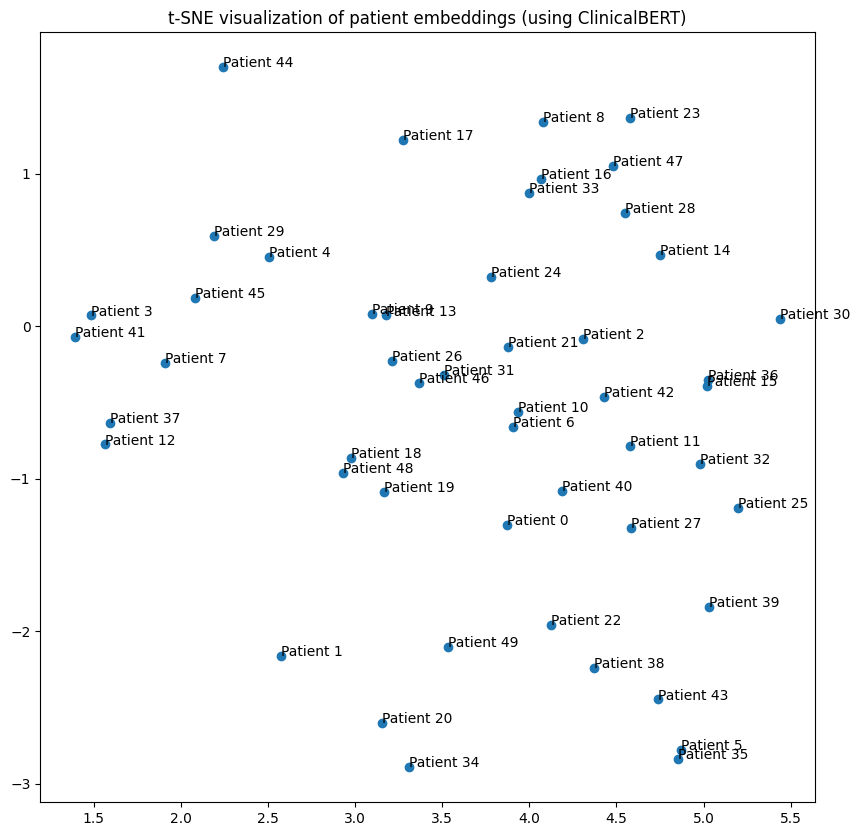

In [178]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions of embeddings for visualization
tsne = TSNE(n_components=2, random_state=42)
patient_embeddings_2d = tsne.fit_transform(patient_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 10))
plt.scatter(patient_embeddings_2d[:, 0], patient_embeddings_2d[:, 1])

# Annotate points with patient indices
for i in range(len(patient_embeddings_2d)):
    plt.annotate(f"Patient {i}", (patient_embeddings_2d[i, 0], patient_embeddings_2d[i, 1]))

plt.title("t-SNE visualization of patient embeddings (using ClinicalBERT)")
plt.show()
